In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy import signal

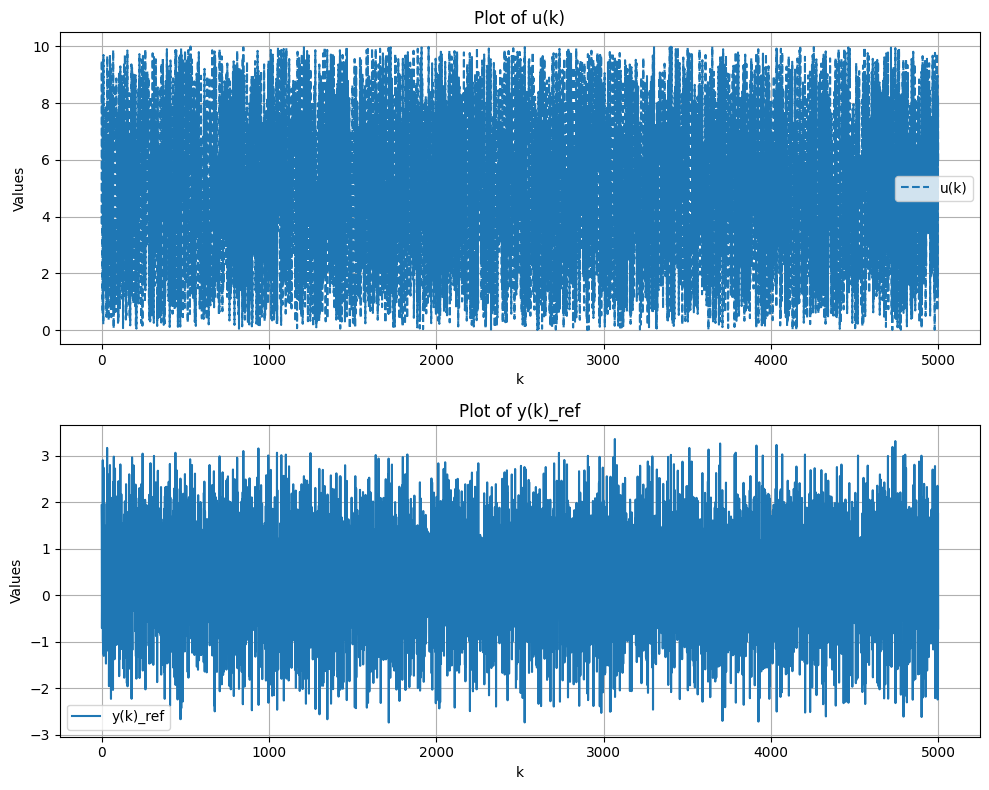

In [2]:
# Define the number of samples
k_max = 5000
jumlah_data_training=int(0.6*k_max)
#jumlah_data_testing=int(0.4*k_max)
t = np.linspace(0, 10*np.pi, k_max)  # Time variable

# Define u(k) as a sine function
np.random.seed(42)
u_k= 10*np.random.rand(k_max)
u_k_1 = np.zeros(k_max)
u_k_2 = np.zeros(k_max)
u_k_1[1:] = u_k[:-1]
u_k_2[2:] = u_k[:-2]

y_k_ref= np.full(k_max, np.nan)
# Generate y(k) for k = 0 to k_max
for k in range(0, k_max):
    if k == 0:
        y_k_ref[k] = 1 / (1 + (0)**2) + 0.25 * u_k[k] - 0.3 * 0
    else:
        y_k_ref[k] = 1 / (1 + (y_k_ref[k-1])**2) + 0.25 * u_k[k] - 0.3 * u_k[k-1]
        
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot u_k in the first subplot
ax1.plot(range(k_max), u_k, label='u(k)', linestyle='--')
ax1.set_xlabel('k')
ax1.set_ylabel('Values')
ax1.set_title('Plot of u(k)')
ax1.legend()
ax1.grid(True)

# Plot y_k_ref in the second subplot
ax2.plot(range(k_max), y_k_ref, label='y(k)_ref', linestyle='-')
ax2.set_xlabel('k')
ax2.set_ylabel('Values')
ax2.set_title('Plot of y(k)_ref')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [3]:
# Normalization function
def normalize(data):
    return 2 * (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0)) - 1

def denormalize(normalized_data, data):
    return (normalized_data + 1) / 2 * (np.max(data, axis=0) - np.min(data, axis=0)) + np.min(data, axis=0)

def pergerseran_data(data):
    data_k_1=np.zeros_like(data)
    data_k_1[1:]=data[:-1]
    data_k_2=np.zeros_like(data)
    data_k_2[2:]=data[:-2]
    return data_k_1,data_k_2


In [4]:
# normalisasi
u_k_norm= normalize(u_k)
y_k_ref_norm = normalize(y_k_ref)
u_k_1_norm, u_k_2_norm= pergerseran_data(u_k_norm)
y_k_1_norm, y_k_2_norm=np.full(k_max, np.nan), np.full(k_max, np.nan)
#y_k_1_norm[:1], y_k_2_norm[:2]=np.zeros(1), np.zeros(2)

data = np.float64(np.array([y_k_1_norm, y_k_2_norm, u_k_norm, u_k_1_norm, u_k_2_norm])).T
data_df= pd.DataFrame(data, columns=['y(k-1)', 'y(k-2)', 'u(k)', 'u(k-1)', 'u(k-2)'])
data_df=data_df[:]
data_df

,y(k-1),y(k-2),u(k),u(k-1),u(k-2)
0,NaN,NaN,-0.250723,0.000000,0.000000
1,NaN,NaN,0.901964,-0.250723,0.000000
2,NaN,NaN,0.464395,0.901964,-0.250723
3,NaN,NaN,0.197646,0.464395,0.901964
4,NaN,NaN,-0.687894,0.197646,0.464395
...,...,...,...,...,...
4995,NaN,NaN,0.795299,-0.863102,0.297287
4996,NaN,NaN,-0.761191,0.795299,-0.863102
4997,NaN,NaN,-0.344145,-0.761191,0.795299
4998,NaN,NaN,0.631947,-0.344145,-0.761191


In [5]:
data_df.drop(data_df.index[0:2], inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.loc[0, ['y(k-1)', 'y(k-2)']] = [y_k_ref_norm[0], y_k_ref_norm[1]]
y_k_ref_norm=y_k_ref_norm[2:]
y_k_ref=y_k_ref[2:]
data_df= data_df[:jumlah_data_training]
data_df

,y(k-1),y(k-2),u(k),u(k-1),u(k-2)
0,0.531852,0.376919,0.464395,0.901964,-0.250723
1,NaN,NaN,0.197646,0.464395,0.901964
2,NaN,NaN,-0.687894,0.197646,0.464395
3,NaN,NaN,-0.687942,-0.687894,0.197646
4,NaN,NaN,-0.883822,-0.687942,-0.687894
...,...,...,...,...,...
2995,NaN,NaN,-0.380265,-0.685384,0.731077
2996,NaN,NaN,-0.419762,-0.380265,-0.685384
2997,NaN,NaN,0.743317,-0.419762,-0.380265
2998,NaN,NaN,0.345778,0.743317,-0.419762


In [6]:
import json
def inisiasi_awal():
    # Specify the file name
    file_name = 'weight_bias_tahap1_adam.json'

    # Open the file in read mode
    with open(file_name, 'r') as file:
        # Load the JSON data into a dictionary
        weight_bias_dict = json.load(file)
    weight={}
    bias={}
    i=1
    for key, value in weight_bias_dict.items():
        print(key)
        if 'W%d'%i in key:
            weight[key]=np.array(value)
        else:
            bias[key]=np.array(value)
        i+=1
    return weight, bias

In [7]:
def tanh_activation(x):
    return np.divide((1-np.exp(-x)),(1+np.exp(- x)))
def tanh_derivative(x):
    g= np.divide(1-np.exp(-x), (1+np.exp(-x)))
    dummy=np.multiply((1+g), (1-g) )/2
    return dummy

def sigmoid_activation(x):
    return 1/(1+np.exp(-x))
def sigmoid_derivative(x):
    return np.multiply(sigmoid_activation(x), (1-sigmoid_activation(x)))

def relu_activation(x):
    return np.maximum(0,x)
def relu_derivative(x):
    return np.where(x>0, 1, 0)

def forward_propagation(weight, bias, X, fungsi_aktivasi="tanh"):
    A={"A0":X}
    z={}
    # layer input ke hidden layer
    jumlah_sampel=X.shape[0]
    jumlah_fitur=X.shape[1]
    for i in range(1, len(weight)+1):
        W=weight[f'W{i}']
        b=bias[f'b{i}']
        z[f'z{i}'] = (np.dot(W, A[f'A{i-1}'].T) + b).T
        if i==len(weight): # output layer
            A[f'A{i}']= z[f'z{i}'] # linear activation
        else: # hidden layer
            if fungsi_aktivasi=="tanh":
                A[f'A{i}']=tanh_activation(z[f'z{i}'])
            elif fungsi_aktivasi=="sigmoid":
                A[f'A{i}']=sigmoid_activation(z[f'z{i}'])
            elif fungsi_aktivasi=="relu":
                A[f'A{i}']=relu_activation(z[f'z{i}'])

        assert A[f'A{i}'].shape == (jumlah_sampel,W.shape[0]), ("shape  A salah !: "+str(A[f'A{i}'].shape) )

    return A,z

# A, z=forward_propagation(weight, bias, data)
# for key, value in z.items():
#     if isinstance(value, np.ndarray):
#         print(f"{key}: {value.shape}")
# for key, value in A.items():
#     if isinstance(value, np.ndarray):
#         print(f"{key}: {value.shape}")

In [8]:
def cost_function(Y_true, Y_pred):

    if not isinstance(Y_true, np.ndarray):
        Y_true=Y_true.to_numpy()
    assert Y_true.shape ==Y_pred.shape, ("shape  Y_prediksi salah !: "+str(Y_pred.shape) )

    return -np.mean(np.square(Y_true-Y_pred))

# last_key = sorted(A.keys())[-1]
# print(last_key)
# cost_error=cost_function(y_k_ref.reshape(-1,1), A[last_key])
# cost_error

In [9]:
def back_propagation(weight, bias, A,z, Y_true, fungsi_aktivasi="tanh"):
    dW = {}
    db = {}
    jumlah_sampel=A['A0'].shape[0]
    last_key = sorted(A.keys())[-1]
    Y_pred=A[last_key]
    if not isinstance(Y_true, np.ndarray):
        Y_true=Y_true.to_numpy()
    assert Y_true.shape ==Y_pred.shape, ("shape  Y_prediksi salah !: "+str(Y_pred.shape) )
    
    for i in reversed(range(1, len(weight) + 1)):
        if i == len(weight):  # output layer
            dz = Y_pred - Y_true
        else:  # hidden layer
            if fungsi_aktivasi=="tanh":
                dz = np.dot(weight[f'W{i+1}'].T, dz.T).T * tanh_derivative(z[f'z{i}'])
            elif fungsi_aktivasi=="sigmoid":
                dz = np.dot(weight[f'W{i+1}'].T, dz.T).T * sigmoid_derivative(z[f'z{i}'])
            elif fungsi_aktivasi=="relu":
                dz = np.dot(weight[f'W{i+1}'].T, dz.T).T * relu_derivative(z[f'z{i}'])
        dW[f'dW{i}'] = (2 / jumlah_sampel) * np.dot(dz.T, A[f'A{i-1}'])
        db[f'db{i}'] = (2 / jumlah_sampel)* np.sum(np.dot(dz.T, 1), axis=1, keepdims=True)
        assert dW[f'dW{i}'].shape == weight[f'W{i}'].shape, ("shape  dW2 salah !: " + str(dW[f'dW{i}'].shape))
 
    return dW, db

# dW,db=back_propagation(weight, bias, A,z, y_k_ref_norm.reshape(-1,1))

# for key, value in dW.items():
#     if isinstance(value, np.ndarray):
#         print(f"{key}: {value.shape}")
# for key, value in db.items():
#     if isinstance(value, np.ndarray):
#         print(f"{key}: {value.shape}")

In [10]:
def batch_update(learning_rate, weight, bias, dW, db):

    for i in range(1, len(weight)+1):
        weight[f'W{i}'] = weight[f'W{i}'] - learning_rate * dW[f'dW{i}']
        bias[f'b{i}'] = bias[f'b{i}'] - learning_rate * db[f'db{i}']
    return weight, bias

In [11]:
def prediksi_jadi_input(prediksi):
    index_sebelum_kosong= data_df['y(k-1)'].last_valid_index()

    kolom_dipilih=data_df.columns.get_loc('y(k-1)')

    if index_sebelum_kosong+1 < len(data_df):
         # untuk y(k-1)
        data_df.iloc[[index_sebelum_kosong+1], [kolom_dipilih]] = prediksi
        # untuk y(k-2)
        data_df.iloc[[index_sebelum_kosong+1], [kolom_dipilih+1]] = data_df.iloc[[index_sebelum_kosong], [kolom_dipilih]]

In [12]:
data_df

,y(k-1),y(k-2),u(k),u(k-1),u(k-2)
0,0.531852,0.376919,0.464395,0.901964,-0.250723
1,NaN,NaN,0.197646,0.464395,0.901964
2,NaN,NaN,-0.687894,0.197646,0.464395
3,NaN,NaN,-0.687942,-0.687894,0.197646
4,NaN,NaN,-0.883822,-0.687942,-0.687894
...,...,...,...,...,...
2995,NaN,NaN,-0.380265,-0.685384,0.731077
2996,NaN,NaN,-0.419762,-0.380265,-0.685384
2997,NaN,NaN,0.743317,-0.419762,-0.380265
2998,NaN,NaN,0.345778,0.743317,-0.419762


In [13]:
data_df=data_df.copy()
i=0
cost_array=[]
learning_rate=0.1
weight, bias=inisiasi_awal()
y_k_ref_norm_train=y_k_ref_norm[:jumlah_data_training].reshape(-1,1)
learning_rate_decay=0.001
while i <= data_df.shape[0]-1:
    X= data_df.dropna().to_numpy()

    A, z=forward_propagation(weight, bias, X, fungsi_aktivasi="tanh")
    last_key = sorted(A.keys())[-1]
    y_k_pred=A[last_key]
    prediksi_jadi_input(y_k_pred[-1])
    cost_error=cost_function(y_k_ref_norm_train[:i+1], A[last_key])
    cost_array.append(cost_error)
    dW,db=back_propagation(weight, bias, A,z, y_k_ref_norm_train[:i+1], fungsi_aktivasi="tanh")
    weight, bias =batch_update(0.1, weight, bias, dW, db)
    
    if i%500==0 and i!=0 or i==data_df.shape[0]-1:
            print("itersi ke-", i)
            print("cost error: ", cost_error)
            print("learning_rate:", learning_rate)
            learning_rate=learning_rate*1/(1+learning_rate_decay*i)

    #print(y_k_pred[-1])
    i+=1

W1
W2
b1
b2
itersi ke- 500
cost error:  -7.39954661091878e-06
learning_rate: 0.1
itersi ke- 1000
cost error:  -4.654806927940889e-06
learning_rate: 0.06666666666666667
itersi ke- 1500
cost error:  -3.765534606096176e-06
learning_rate: 0.03333333333333333
itersi ke- 2000
cost error:  -3.2844086777515625e-06
learning_rate: 0.013333333333333332
itersi ke- 2500
cost error:  -2.904807667063851e-06
learning_rate: 0.0044444444444444444
itersi ke- 2999
cost error:  -2.702471687965577e-06
learning_rate: 0.0012698412698412698


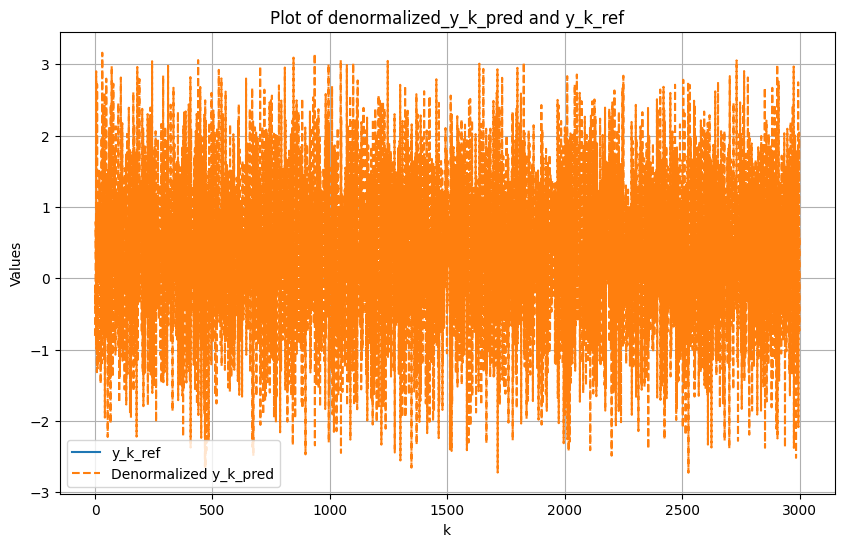

In [20]:
import pandas as pd


denormalized_y_k_pred = denormalize(y_k_pred, y_k_ref)

plt.figure(figsize=(10, 6))


# Plot y_k_pred
plt.plot(y_k_ref[jumlah_data_training], label='y_k_ref', linestyle='-')

# Plot denormalized_y_k_pred
plt.plot(denormalized_y_k_pred, label='Denormalized y_k_pred', linestyle='--')

# Add labels and title
plt.xlabel('k')
plt.ylabel('Values')
plt.title('Plot of denormalized_y_k_pred and y_k_ref')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Display the plot
plt.show()

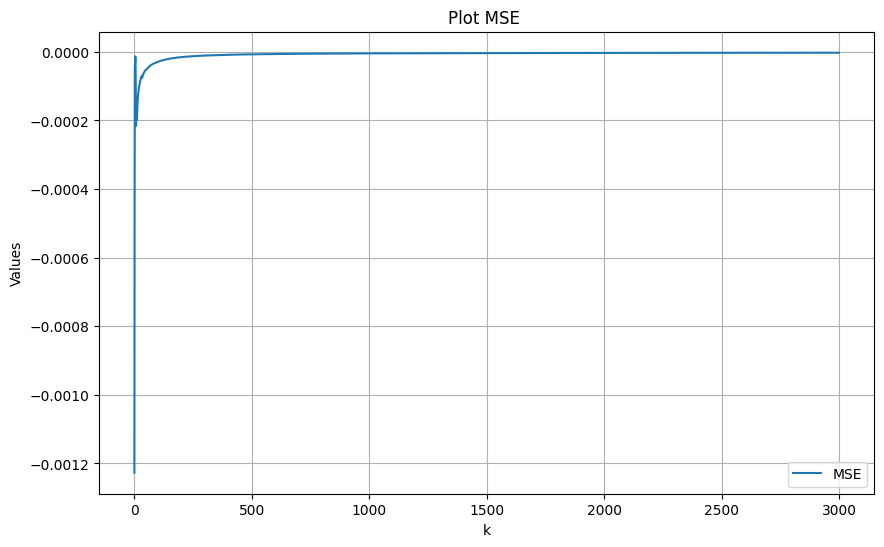

In [15]:
plt.figure(figsize=(10, 6))

# Plot denormalized_y_k_pred
plt.plot(cost_array, label='MSE')


# Add labels and title
plt.xlabel('k')
plt.ylabel('Values')
plt.title('Plot MSE ')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Display the plot
plt.show()

In [16]:
import json
import numpy as np

# Assuming W1, W2, b1, and b2 are already defined as numpy arrays
weight_bias_dict = {
}
weight_bias_dict.update(weight)
weight_bias_dict.update(bias)
for key, value in weight_bias_dict.items():
    weight_bias_dict[key] = value.tolist() 
print(weight_bias_dict)

# Specify the file name
file_name = 'weight_bias_tahap2_uk.json'

# Open the file in write mode
with open(file_name, 'w') as file:
    # Write the dictionary to the file in JSON format
    json.dump(weight_bias_dict, file)

{'W1': [[-0.001836219353371205, -9.205859995191324e-05, -0.00010606613897595414, 0.0007772563381631562, -0.0009928834073556555], [-0.0008714615811702783, -3.940674964659553e-05, -4.6076105021112375e-05, 0.00036931828150348105, -0.0004751997705069777], [0.002147447176980977, 0.00010778277593456018, 0.00012453147342249429, -0.0009091764951247605, 0.0011609416122649054], [0.04001162108706239, 2.3382120468686236e-06, 0.3179748663884981, -0.08225240106284407, -0.01367866076242902], [-8.894705882296254, 0.002129590495089088, -0.006635281869226294, -0.001055788112540938, 0.0005521283095026274], [-2.848849140665096, 0.004233502863708013, 0.002711124287948166, -0.0052218158281250975, 0.0059385164221457095], [-6.637586211112056, -0.0006462725341952486, -0.0027436386215087287, 0.006883069797298703, 0.00025352764562331807], [-0.0017319198881014866, -8.677424862649472e-05, -9.989253639782623e-05, 0.0007330620963900724, -0.0009365678015080632], [-0.10257189488061325, 0.0005253909475817858, -0.056146